<a href="https://colab.research.google.com/github/qsdcfd/TIL/blob/TIL/Study__401/ko_chabot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone "https://github.com/songys/Chatbot_data.git"

Cloning into 'Chatbot_data'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 57 (delta 21), reused 6 (delta 3), pack-reused 18
Unpacking objects: 100% (57/57), done.


In [2]:
import os   #디렉토리 관리
import re   #문자열 정규식

import numpy as np   #행렬 연산
import pandas as pd   #데이터 프레임
import matplotlib.pyplot as plt   #데이터 시각화

import tensorflow as tf   #신경망
import tensorflow_datasets as tfds   #단어장 만들기

In [3]:
#/content/Chatbot_data/ChatbotData.csv
dataset = pd.read_csv("/content/Chatbot_data/ChatbotData.csv")
dataset.sample(5)

,Q,A,label
9725,매일매일 사랑해,표현하는 게 좋죠.,2
5859,내 사랑의 끝은 이별이지만,더 좋은 시작이 있을 거예요.,1
1297,돈 빌려줬는데 연락 두절,차용증 썼길 바랍니다.,0
8982,계속 그 사람 생각만 해.,자연스러운 현상이에요.,2
3980,잠 와,잠을 깨요! 기운 내요!!,0


In [4]:
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


In [5]:
#전처리 함수===========================
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([0-9?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣0-9?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence
#End===================================


#문장 전처리===========================
questions, answers = [], []
for idx, row in dataset.iterrows():
    questions.append(preprocess_sentence(row["Q"]))
    answers.append(preprocess_sentence(row["A"]))
#End===================================


#출력부================================
print("*" * 50)
print("Question: {0} ===> {1}".format(dataset["Q"][0], questions[0]))
print("Answer: {0} ===> {1}".format(dataset["A"][0], answers[0]))
print("*" * 50)
print("Question len: {0}\tAnswer len: {1}".format(len(questions), len(answers)))
#End===================================

**************************************************
Question: 12시 땡! ===> 1 2 시 땡 !
Answer: 하루가 또 가네요. ===> 하루가 또 가네요 .
**************************************************
Question len: 11823	Answer len: 11823


************************************************************
question min len: 1
question max len: 16
question avg len: 3.9808001353294427

answer min len: 1
answer max len: 24
answer avg len: 4.720375539203248
************************************************************


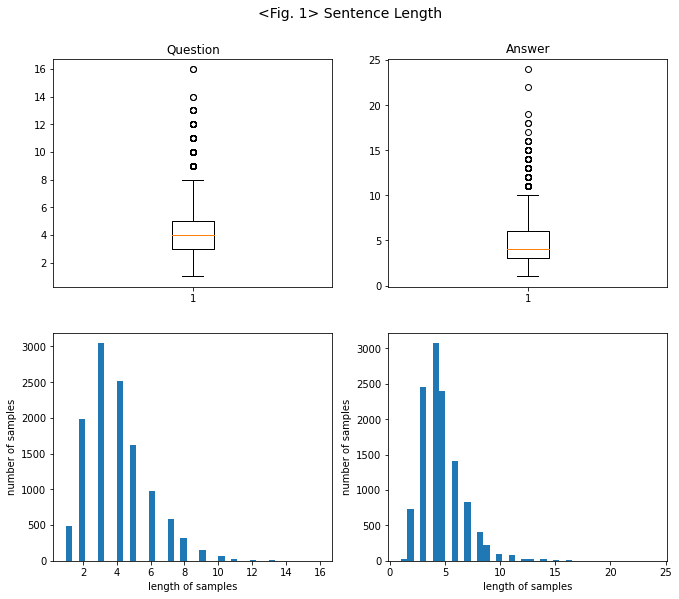

In [6]:
question_len = [len(s.split()) for s in questions]   #원문에 대한 문장 길이
answers_len = [len(s.split()) for s in answers]   #요약문에 대한 문장 길이


#출력부============================
print("*" * 60)
print('question min len: {}'.format(np.min(question_len)))
print('question max len: {}'.format(np.max(question_len)))
print('question avg len: {}'.format(np.mean(question_len)))

print('\nanswer min len: {}'.format(np.min(answers_len)))
print('answer max len: {}'.format(np.max(answers_len)))
print('answer avg len: {}'.format(np.mean(answers_len)))
print("*" * 60)
#End==============================


#시각화===========================
data_list = (question_len, answers_len)
title_list = ("Question", "Answer")

plt.figure(figsize=(11, 9))
plt.suptitle("<Fig. 1> Sentence Length", fontsize=14)
plt.subplots_adjust(top=0.9, wspace=0.2)

for idx, data in enumerate(data_list):
    idx += 1
    plt.subplot(2, 2, idx)
    
    plt.boxplot(data)
    plt.title(title_list[idx-1])
    
    plt.subplot(2, 2, idx + 2)
    plt.hist(data, bins=40)
    plt.xlabel("length of samples")
    plt.ylabel("number of samples")

plt.show()
#End==============================

In [7]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers,
    target_vocab_size=8192   #단어사전 크기
)

In [8]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
VOCAB_SIZE = tokenizer.vocab_size + 2   #시작, 종료 토큰 추가 시의 vocab 크기


#출력부================================
print("*" * 50)
print('START_TOKEN:' ,START_TOKEN)
print('END_TOKEN:' ,END_TOKEN)
print("VOCAB SIZE:", VOCAB_SIZE)
print("*" * 50)
#End===================================

**************************************************
START_TOKEN: [8145]
END_TOKEN: [8146]
VOCAB SIZE: 8147
**************************************************


In [9]:
MAX_LENGTH = 10

#================================
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post'
    )
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post'
    )
    return tokenized_inputs, tokenized_outputs
#End===================================


questions, answers = tokenize_and_filter(questions, answers)


#출력부================================
print("*" * 50)
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))
print("*" * 50)
#End===================================

**************************************************
필터링 후의 질문 샘플 개수: 9084
필터링 후의 답변 샘플 개수: 9084
**************************************************


In [10]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000

#데이터셋 생성=============================================
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        #마지막 글자 제외 = END TOKEN 제외
        'dec_inputs': answers[:, :-1]
    },
    {
        #첫 번째 글자 제외 = START TOKEN 제외
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
#End=========================================================


#출력부======================================================
for input_data, output_data in dataset.take(1): break;
rand_idx = np.random.randint(0, BATCH_SIZE)
seq = input_data["inputs"][rand_idx]

print("*" * 70)
for word in seq.numpy():
    try:
        word = tokenizer.subwords[word - 1]
        if word == " , ,": break;
        print(word, end="")
    except:
        pass
print("\n" + "↓" * 35)
print(seq.numpy())
print("*" * 70)
#End=========================================================

**********************************************************************
그녀를_생각할_수록_내가_비참해져 .
↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
[8145  753 1101  788   53 2980 3826    1 8146    0]
**********************************************************************


In [11]:
# 포지셔널 인코딩 레이어++++++++++++++++++++++++++++++++++++++++++++++++++++++
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        #position: 행 크기(=문장 길이), d_model:  임베딩 차원
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    #(pos / 10000 ** 2i / d_model)==============================
    def get_angles(self, position, i, d_model):
        #tf.pow(x, y): x ** y
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles
    #End========================================================
    
    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model
        )

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)   #순차대로 적재
        pos_encoding = tf.transpose(pos_encoding, [1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):   #input과 positional encoding과 합치기
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]
#End++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

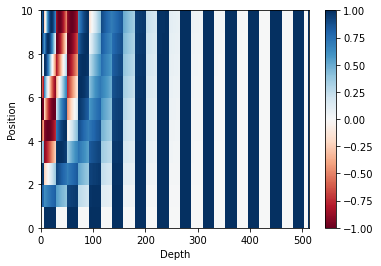

In [12]:
EMBEDDING_SIZE = 512

sample_pos_encoding = PositionalEncoding(MAX_LENGTH, EMBEDDING_SIZE)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, EMBEDDING_SIZE))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [13]:
print("*" * 50)
print(sample_pos_encoding.pos_encoding.shape)
print("↓↓↓↓↓drop duplicate data↓↓↓↓↓")

#중복행 제거
test_pd = pd.DataFrame(sample_pos_encoding.pos_encoding.numpy()[0]).copy()

print(test_pd.drop_duplicates(test_pd.columns.tolist()).shape)
print("*" * 50)

**************************************************
(1, 10, 512)
↓↓↓↓↓drop duplicate data↓↓↓↓↓
(10, 512)
**************************************************


In [14]:


#스케일드 닷 프로덕트 어텐션 함수(Q, K, V, mask)===============
def scaled_dot_product_attention(query, key, value, mask):
    #Q ·K product
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)   #depth=d_k
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    #Key에서 패딩열에 아주 작은 값으로 대체한다.
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output
#End===========================================================

In [15]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [16]:
class MultiHeadAttention(tf.keras.layers.Layer):
    #d_model: 단어 벡터 크기, num_heads: 병렬 처리 개수
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        #assert 문이 False이면 assert 에러 발생
        #assert는 에러문이 발생하지만, 코드가 중단되지는 않는다.
        #즉 단어 벡터 크기가 병렬 처리 개수로 나누었을 때,
        #맞아 떨어져야 잘 작동한 다는 뜻이다.
        assert d_model % self.num_heads == 0

        #하나의 head가 가지는 벡터 크기
        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            #shape(batch_size, MAX_LENGTH, num_heads, depth)
            #=(64, 40, 8, 64)
            inputs, shape=(batch_size, -1, self.num_heads, self.depth)
        )
        #shape(batch_size, num_heads, MAX_LENGTH, depth)
        #=(64, 8, 40, 64)
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        
        # 병렬 연산을 위한 머리를 여러 개 만듭니다+++++++++++
        #num_head 수 만큼 나누기
        #shape(batch_size, num_heads, MAX_LENGTH, depth)
        #=(64, 8, 40, 64)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        #End+++++++++++++++++++++++++++++++++++++++++++++++++
        

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        #shape(batch_size, MAX_LENGTH, num_heads, depth)
        #=(64, 40, 8, 64)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(
            scaled_attention,
            #shape(batch_size, MAX_LENGTH, (num_heads, depth))
            #=(64, 40, 512)
            (batch_size, -1, self.d_model)
        )

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

In [17]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        }
    )

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name
    )


In [18]:
def encoder(
    vocab_size,
    num_layers,
    units,
    d_model,
    num_heads,
    dropout,
    name="encoder"
):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
    inputs=[inputs, padding_mask], outputs=outputs, name=name
    )

In [19]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [20]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask"
    )
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6
    )(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6
    )(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6
    )(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name
    )

In [21]:
def decoder(
    vocab_size,
    num_layers,
    units,
    d_model,
    num_heads,
    dropout,
    name='decoder'
):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask'
    )

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name
    )

In [22]:
def transformer(
    vocab_size,
    num_layers,
    units,
    d_model,
    num_heads,
    dropout,
    name="transformer"
):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name='enc_padding_mask'
    )(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None), name='look_ahead_mask'
    )(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name='dec_padding_mask'
    )(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])
    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)




In [23]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3139840     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

In [24]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none'
    )(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    #패딩이 아닌 단어만 살리기
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

Text(0.5, 0, 'Train Step')

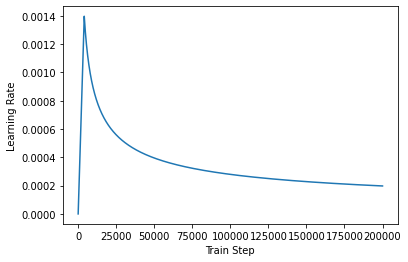

In [25]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
    
#시각화=====================
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
#End========================

In [26]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])


In [27]:
EPOCHS = 25
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/25
142/142 [==============================] - 14s 29ms/step - loss: 5.6083 - accuracy: 0.0886
Epoch 2/25
142/142 [==============================] - 4s 29ms/step - loss: 4.7343 - accuracy: 0.2023
Epoch 3/25
142/142 [==============================] - 4s 28ms/step - loss: 3.9352 - accuracy: 0.2152
Epoch 4/25
142/142 [==============================] - 5s 33ms/step - loss: 3.5130 - accuracy: 0.2200
Epoch 5/25
142/142 [==============================] - 4s 29ms/step - loss: 3.2905 - accuracy: 0.2314
Epoch 6/25
142/142 [==============================] - 4s 28ms/step - loss: 3.1008 - accuracy: 0.2421
Epoch 7/25
142/142 [==============================] - 4s 28ms/step - loss: 2.9047 - accuracy: 0.2577
Epoch 8/25
142/142 [==============================] - 4s 28ms/step - loss: 2.6934 - accuracy: 0.2795
Epoch 9/25
142/142 [==============================] - 4s 29ms/step - loss: 2.4545 - accuracy: 0.3073
Epoch 10/25
142/142 [==============================] - 5s 36ms/step - loss: 2.1993 - accur

In [28]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)   #정규식을 이용한 전처리

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0
    )

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [29]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size]
    )

    print('입력 : {}'.format(sentence))
    return ('출력 : {}'.format(predicted_sentence))

In [30]:
print("*" * 50)
print(sentence_generation('밥 먹었니?'), end="\n\n")
print(sentence_generation('너 누구야?'), end="\n\n")
print(sentence_generation('안녕~'), end="\n\n")
print(sentence_generation('여행가자'), end="\n\n")
print(sentence_generation('사랑이 뭐야?'), end="\n\n")
print("*" * 50)

**************************************************
입력 : 밥 먹었니?
출력 : 배고프지 않아요 .

입력 : 너 누구야?
출력 : 저는 마음을 이어주는 위로봇입니다 .

입력 : 안녕~
출력 : 안녕하세요 .

입력 : 여행가자
출력 : 아직 안 자요 .

입력 : 사랑이 뭐야?
출력 : 신뢰입니다 .

**************************************************
